## CLI/Functional analysis of patch clamp data

The pyAPisolation package has several entry points for analysis. While most of the package is currently built for use with ABF, I have been making progress in making functions that accept and process various data types.

*** Note: For install instructions please see the main readme ***

### Data Set-up

Majority of the analysis functions should now accept data in the form of a numpy array (at a minimum). For higher level functions this data should be in the form of `[Sweeps, Time points]`. In this case, `Sweeps` refers to each set of episodic stimulation applied to a cell. For each cell, you will need three arrays:  
- x : The time array (in seconds)
- y : The voltage response array (in mV)
- c : The applied stimuli (in pA)

Each array will need to have equal size. Below we load one of our abf files into numpy arrays for further analysis. However, these arrays could be sourced from anywhere.

==== Data Shapes ===
x shape: (15, 250000), y shape: (15, 250000), c shape: (15, 250000)


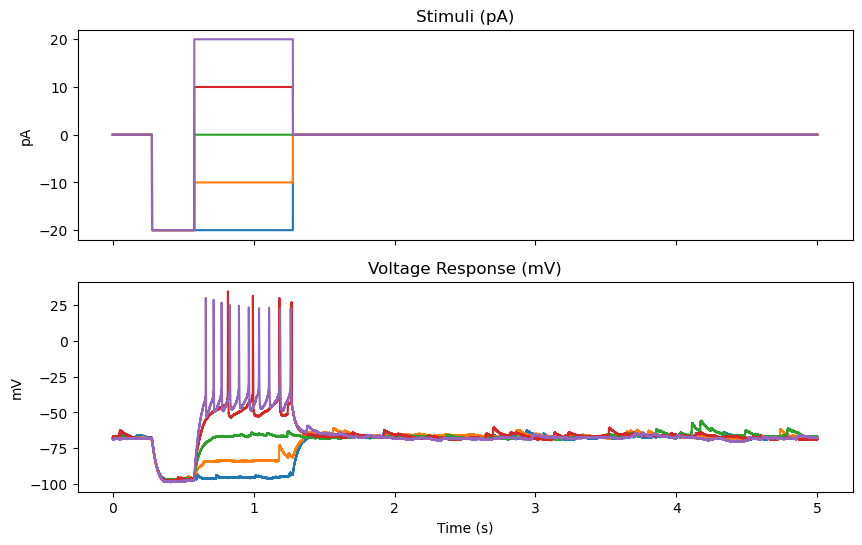

In [3]:
import pyAPisolation.loadFile as lf
import numpy as np
import matplotlib.pyplot as plt

data_path = './data/demo_data_2.abf'

x,y,c = lf.loadABF(data_path)
print("==== Data Shapes ===")
print(f"x shape: {x.shape}, y shape: {y.shape}, c shape: {c.shape}") #should be 15 sweeps

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].set_title('Stimuli (pA)')
ax[0].set_ylabel('pA')

ax[1].set_title('Voltage Response (mV)')
ax[1].set_ylabel('mV')
ax[1].set_xlabel('Time (s)')
for i in range(5):
    ax[1].plot(x[i,:], y[i,:])
    ax[0].plot(x[i,:], c[i,:])

### Spike Feature analysis

The majority of the code for extracting spiking features is in `pyAPisolation.featureExtractor`. In this case, the functions to take note of are `analyze` and `batch_feature_extract`. These handle a variety inputs and output dataframes with all features used in Sunstrum et. al. 202X.    
Lets take a look at the call signature for analyze:

```python
#=== functional interface for programmatic use ===
def analyze(x=None, y=None, c=None, file=None, param_dict=DEFAULT_DICT, return_summary_frames=True):
    """ Runs the ipfx feature extractor over a single sweep, set of sweeps, or file. Returns the standard ipfx dataframe, and summary dataframes (if requested).
    Args:
        x (np.array, optional): The time array of the sweeps. Defaults to None.
        y (np.array, optional): The voltage array of the sweeps. Defaults to None.
        c (np.array, optional): The current array of the sweeps. Defaults to None.
        file (str, optional): The file path. Defaults to None.
        param_dict (dict, optional): The dictionary of parameters that will be passed to the feature extractor. Defaults to None.
        return_summary_frames (bool, optional): If True, will return the summary dataframes. Defaults to False.
    Returns:
        df_raw_out: A dataframe of the full data as returned by the ipfx feature extractor. Consists of all the sweeps in the files stacked on top of each other.
        (optional) df_spike_count (pd.DataFrame): The dataframe that contains the standard ipfx features for the sweep, oriented sweepwise
        (optional) df_running_avg_count (pd.DataFrame): The dataframe that contains the standard ipfx features for the consecutive spikes in the sweep
    """
```
In this case, we simply need to pass in either a filepath or the (x,y,c) arrays. We also want to pass in the `param_dict`, this defines the analysis settings. Majority of these are thresholds for action potential detection 

In [ ]:
from 